In [5]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
import torch
from tqdm import tqdm
import dvu
from typing import List
dvu.set_style()
import pandas as pd
from os.path import join as oj
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sys
from auggam import config
import joblib

sys.path.append('../experiments')
# import config
pd.set_option('display.max_rows', None)

def get_scores(row, phrase):
    tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
    model = AutoModel.from_pretrained(row.checkpoint)
    logistic = row.model
    device = 'cuda'
    tokens = tokenizer(phrase.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
    model = model.to(device)
    with torch.no_grad():
        output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
    embs = output[row.layer].cpu().detach().numpy()
    # pkl.dump(embs, open('../results/embs_sst_unigram_bigram.pkl', 'wb'))
    scores = embs @ row.model.coef_.T
    return scores

r = joblib.load('../results/fitted_results_aggregated.pkl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract the relevant model

# sst (not sst2) dataset

In [3]:
dset = datasets.load_dataset('sst', 'dictionary')

lens = list(map(lambda x: len(x.split()), dset['dictionary']['phrase']))
idxs = np.array(lens) <= 2
label = np.array(dset['dictionary']['label'])[idxs]
phrase = np.array(dset['dictionary']['phrase'])[idxs]

Found cached dataset sst (/home/chansingh/.cache/huggingface/datasets/sst/dictionary/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# bigrams
cached_model_fname = oj('..', 'results', 'sst_bert_finetuned_ngrams=2.pkl')
row = pkl.load(open(cached_model_fname, "rb"))
scores = get_scores(row, phrase)
print('bigram', scipy.stats.spearmanr(label, scores))

# get linear scores
d = joblib.load('../results/bow_sst2.pkl')
mod = d['model']
vec = d['vectorizer']
mat = vec.transform(phrase)
scores_linear = mat @ mod.coef_.T
print('bigram lin', scipy.stats.spearmanr(label, scores_linear))

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

bigram SignificanceResult(statistic=0.6345052362075632, pvalue=0.0)
bigram lin SignificanceResult(statistic=0.3910786688893779, pvalue=0.0)


In [23]:
# trigrams
idxs_tri = np.array(lens) == 3
label_tri = np.array(dset['dictionary']['label'])[idxs_tri]
phrase_tri = np.array(dset['dictionary']['phrase'])[idxs_tri]
scores_tri = get_scores(row, phrase_tri)
scores_dict = {
    phrase_tri[i]: scores_tri[i] for i in range(phrase_tri.shape[0])
}
# print('trigram', scipy.stats.spearmanr(label_tri, scores_tri))

# get linear scores
df3 = pd.read_csv(oj(config.misc_dir, 'df_trigram_sst.csv'), index_col=0)
coef_dict = {}
for i in range(df3.shape[0]):
    coef_dict[df3['trigram'][i]] = df3['coef'][i]
label_tri_subset = []
coef_tri_lin_subset = []
coef_tri_subset = []

for i in range(phrase_tri.shape[0]):
    if phrase_tri[i].strip() in coef_dict:
        label_tri_subset.append(label_tri[i])
        coef_tri_lin_subset.append(coef_dict[phrase_tri[i]])
        coef_tri_subset.append(scores_dict[phrase_tri[i]])
    else:
        label_tri_subset.append(label_tri[i])
        coef_tri_lin_subset.append(0) #coef_dict[phrase_tri[i]])
        coef_tri_subset.append(scores_dict[phrase_tri[i]])


print('trigram', scipy.stats.spearmanr(label_tri_subset, coef_tri_subset))
print('trigram lin', scipy.stats.spearmanr(label_tri_subset, coef_tri_lin_subset))

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


trigram SignificanceResult(statistic=0.7081280146232627, pvalue=0.0)
trigram lin SignificanceResult(statistic=0.4927797653694256, pvalue=0.0)


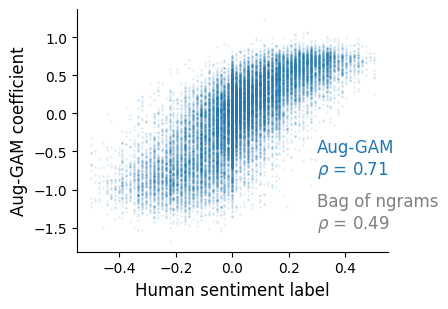

In [24]:
# l = label
# s = scores
l = label_tri
s = scores_tri

plt.figure(figsize=(4.5, 3.2))
# plt.title('B', fontweight='bold', loc='left')
# plt.grid()
plt.plot(l - 0.5, s, '.', alpha=0.08, ms=2, color='C0')
# df = pd.DataFrame.from_dict({'score': scores.flatten(), 'lab': label.flatten()})
# sns.lmplot(data=df, x='score', y='lab',markers='.')
plt.ylabel('Aug-GAM coefficient', fontsize='large') #, fontsize='large')
plt.xlabel('Human sentiment label', fontsize='large') #, fontsize='large')

# bigrams
# plt.text(0.3, -0.8, 'Aug-GAM\n$\\rho$ = 0.63', color='C0', fontsize='large')
# plt.text(0.3, -1.5, 'Bag of ngrams\n$\\rho$ = 0.39', color='gray', fontsize='large')

# trigrams
# bigrams
plt.text(0.3, -0.8, 'Aug-GAM\n$\\rho$ = 0.71', color='C0', fontsize='large')
plt.text(0.3, -1.5, 'Bag of ngrams\n$\\rho$ = 0.49', color='gray', fontsize='large')

plt.tight_layout()
# plt.savefig('sst_auggam.png', dpi=300, bbox_inches='tight')
# plt.savefig('sst_auggam.pdf', dpi=300, bbox_inches='tight')
plt.savefig('sst_auggam_tri.png', dpi=300, bbox_inches='tight')